## Evaluates the data of the samples after preprocessing
This part of the analysis was done before the metadata extraction. The data is used directly and not via the metadata tables.

In [1]:
import pandas as pd
import glob
import os
import re
import utility_functions as utility
from ipyparallel import require

In [2]:
data_directories = [
    'D:\\Desktop\\Simulation_Data\\20211013-232317\\Data'
]
@require('pandas as pd', 're', 'os')
def read_data(path: str):
    data_df = pd.read_csv(path)
    ratio, sample = re.findall(r'\d+', os.path.split(os.path.dirname(path))[1])
    data_df['Sample'] = int(sample)
    data_df['Energy_Factor'] = ratio
    return data_df


files = [file for directory in data_directories for file in glob.iglob(os.path.join(directory, '**', '*complete.csv'), recursive=True)]
df = pd.concat(utility.process(read_data, files))\
    .drop(columns=['MessageType','DataType', 'Rotation','Position.X','Position.Y'])
df.describe()

read_data:   0%|          | 0/16 [00:00<?, ?tasks/s]

Cycle            Id        Energy        Sample
count  7.555796e+07  7.555796e+07  7.555796e+07  7.555796e+07
mean   3.597499e+03  1.450000e+01  7.779051e-03  1.745121e+02
std    2.077307e+03  8.655441e+00  3.047368e-01  1.010381e+02
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    1.798000e+03  7.000000e+00  0.000000e+00  8.700000e+01
50%    3.597000e+03  1.500000e+01  0.000000e+00  1.750000e+02
75%    5.396000e+03  2.200000e+01  0.000000e+00  2.620000e+02
max    7.199000e+03  2.900000e+01  9.311250e+01  3.490000e+02

Excluding the last and first 60 seconds where data is inconsistent. Calculating the mean energy per sample and cycle afterwards.

In [3]:
df = df[df['Cycle'].between(60 , 7140, inclusive='right')]
sample_group = df.groupby(['Sample', 'Cycle'])
mean_per_cycle = sample_group['Energy'].mean()

Calculating the mean/max/std energy per sample (whole sample not every cycle).

In [4]:
per_cycle_group = mean_per_cycle.groupby('Sample')

energy_df = pd.DataFrame(index = per_cycle_group.groups.keys())
energy_df.index.name = 'Sample'
energy_df['Energy_Mean'] = per_cycle_group.mean()
energy_df['Energy_Max'] = per_cycle_group.max()
energy_df['Energy_Std']= per_cycle_group.std()

Additional cycle metadata

In [5]:
non_zero_cycles = mean_per_cycle[mean_per_cycle > 0].groupby('Sample')
energy_df['Cycles'] = sample_group.size().groupby('Sample').size()
energy_df['Energy_Cycles'] = non_zero_cycles.size()
energy_df['No_Energy_Ratio'] = 1 - energy_df['Energy_Cycles'] / energy_df['Cycles']
energy_df

Energy_Mean  Energy_Max  Energy_Std  Cycles  Energy_Cycles  \
Sample                                                               
0          0.000000    0.000000    0.000000    7081            NaN   
1          0.000187    0.245000    0.005661    7081           10.0   
2          0.000542    0.245000    0.009536    7081           30.0   
3          0.000899    0.488750    0.016287    7081           31.0   
4          0.292197    3.726875    0.406764    7081         4564.0   
...             ...         ...         ...     ...            ...   
345        0.047580    1.373125    0.134242    7081         1432.0   
346        0.000069    0.235000    0.003528    7081            4.0   
347        0.000178    0.238750    0.005445    7081           10.0   
348        0.000221    0.227500    0.005967    7081           13.0   
349        0.000193    0.415625    0.007614    7081            6.0   

        No_Energy_Ratio  
Sample                   
0                   NaN  
1              0.998588  
2              0.995763  
3              0.995622  
4              0.355458  
...                 ...  
345            0.797769  
346            0.999435  
347            0.998588  
348            0.998164  
349            0.999153  

[350 rows x 6 columns]

Average and Std of Energy per sample. Only samples with an average energy greater than 0.01 are counted.

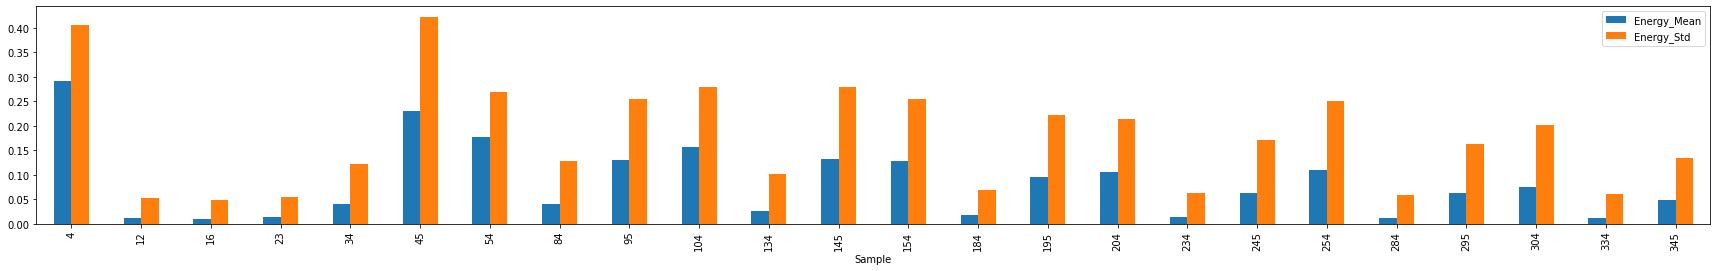

In [6]:
plot = energy_df[energy_df['Energy_Mean'] > 0.01][['Energy_Mean','Energy_Std']].plot(kind='bar')
plot.figure.set_figwidth(30)

Ratio between cycles with and without energy. Only cycles with a ratio of at least 0.1 are displayed.

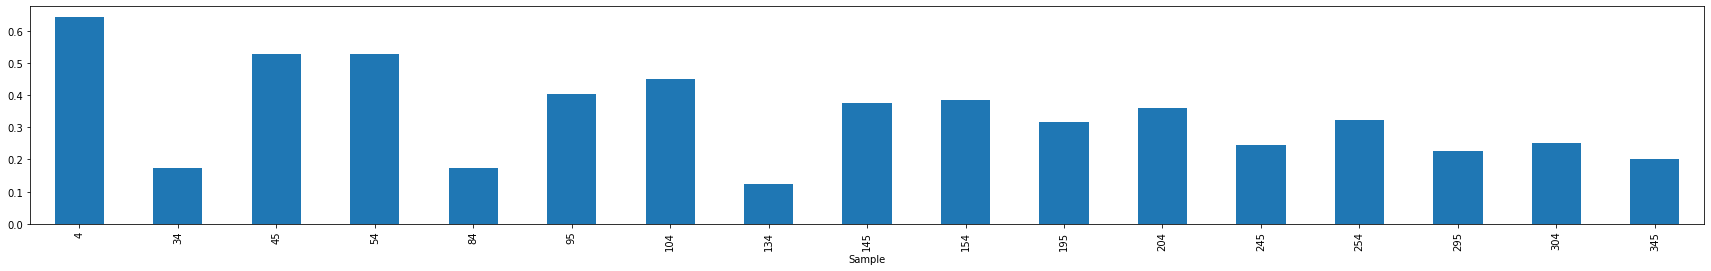

In [7]:
inverted_energy_ratio = 1-energy_df['No_Energy_Ratio']

plot = inverted_energy_ratio[inverted_energy_ratio > 0.1].plot(kind='bar')
plot.figure.set_figwidth(30)

Average Energy in relation to consumption factor. Y-Axis represents the average energy. X-Axis represents reduction of the energy_factor e.g. 50 equals 50% of the original value.

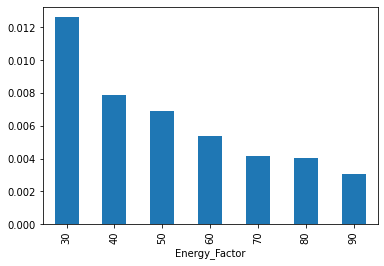

In [11]:
ratio_group = df.groupby( ['Energy_Factor','Cycle'])

ratio_group['Energy'].mean().groupby('Energy_Factor').mean().plot(kind='bar')\
    .get_figure().savefig('Figures/Energy_Factor_Average.png')